# **Image Classification using ConvNet model**

## *Loading Important libraries*

In [ ]:
#Load libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pathlib
import time
import os
import csv
import copy
import shutil
cudnn.benchmark = True
plt.ion()   # interactive mode
import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
from PIL import Image
import cv2

## *Loading the image dataset*

In [ ]:
# /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022
!unzip "/content/sprints-ai-and-ml-competition-2022.zip" -d "/content/sprints-ai-and-ml-competition-2022"

Streaming output truncated to the last 5000 lines.
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7551.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7560.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7565.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7578.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7581.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7586.jpg  
  inflating: /content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set/mountain/7647.jpg  
  inflating: /content/spr

## *Data Augmentation*

In [ ]:
data_transforms = {
    'Scenes training set': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Scenes testing test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
datadir='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022'

image_datasets = {x: datasets.ImageFolder(os.path.join(datadir, x),
                                          data_transforms[x])
                  for x in ['Scenes training set']}

class_names = image_datasets['Scenes training set'].classes

rootdir='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes training set'
for i in class_names:
  os.makedirs(datadir +'/train/' + i)
  os.makedirs(datadir +'/test/' + i)
  source = rootdir + '/' + i
  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  test_ratio = 0.3
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])
  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
  for name in train_FileNames:
    shutil.copy(name, datadir +'/train/' + i)
  for name in test_FileNames:
    shutil.copy(name, datadir +'/test/' + i)

In [ ]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

## *Checking for the GPU device*

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_path='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/train'
test_path='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [ ]:
root=pathlib.Path(train_path)
classes_names=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## *Implementing the model*

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)       
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            
        

In [ ]:
model=ConvNet(num_classes=6).to(device)

## *Important parameters*

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=24
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

9820 4214


## *Trainig the model*

In [ ]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       

Epoch: 0 Train Loss: tensor(6.3574) Train Accuracy: 0.555091649694501 Test Accuracy: 0.5626483151400095
Epoch: 1 Train Loss: tensor(3.2809) Train Accuracy: 0.6771894093686355 Test Accuracy: 0.6473659231134314
Epoch: 2 Train Loss: tensor(2.0279) Train Accuracy: 0.7480651731160897 Test Accuracy: 0.7209302325581395
Epoch: 3 Train Loss: tensor(0.9312) Train Accuracy: 0.8235234215885947 Test Accuracy: 0.7159468438538206
Epoch: 4 Train Loss: tensor(0.6348) Train Accuracy: 0.8624236252545825 Test Accuracy: 0.6953013763644993
Epoch: 5 Train Loss: tensor(0.4153) Train Accuracy: 0.8968431771894094 Test Accuracy: 0.7287612719506408
Epoch: 6 Train Loss: tensor(0.3187) Train Accuracy: 0.9206720977596742 Test Accuracy: 0.730422401518747
Epoch: 7 Train Loss: tensor(0.2154) Train Accuracy: 0.9458248472505092 Test Accuracy: 0.7470336971998102
Epoch: 8 Train Loss: tensor(0.2699) Train Accuracy: 0.9287169042769857 Test Accuracy: 0.7327954437588989
Epoch: 9 Train Loss: tensor(0.1395) Train Accuracy: 0.962

## *Testing*

In [ ]:
train_path='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/train'
pred_path='/content/sprints-ai-and-ml-competition-2022/sprints-ai-and-ml-competition-2022/Scenes testing test'
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes=['0','1','2','3','4','5']
# classes=classes.to(device)

In [ ]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()


ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [ ]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    # image_tensor=transformer(image).type(torch.cuda.FloatTensor)

    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
    #     # transformer.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    # output.cuda()
    
    index=output.cpu().data.numpy().argmax()
    
    pred=classes[index]
    # pred=transformer(pred).float()
    # pred=pred.to(device)

    return pred

In [ ]:
images_path=glob.glob(pred_path+'/*.jpg')
pred_dict={}
for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)
Image_labels=list(pred_dict.keys())
# pred_dict.values()
# print(Image_labels)

## *Results*

In [ ]:
pred_dict

{'23240.jpg': '1',
 '21682.jpg': '5',
 '22464.jpg': '0',
 '20474.jpg': '5',
 '20234.jpg': '5',
 '22989.jpg': '5',
 '23705.jpg': '4',
 '21320.jpg': '2',
 '24022.jpg': '3',
 '24222.jpg': '0',
 '21231.jpg': '3',
 '21329.jpg': '2',
 '22098.jpg': '0',
 '21250.jpg': '1',
 '23174.jpg': '4',
 '23215.jpg': '5',
 '20342.jpg': '4',
 '21986.jpg': '2',
 '23163.jpg': '5',
 '20692.jpg': '3',
 '21309.jpg': '0',
 '20159.jpg': '1',
 '20075.jpg': '5',
 '20276.jpg': '3',
 '22574.jpg': '4',
 '20485.jpg': '1',
 '22245.jpg': '3',
 '736.jpg': '0',
 '21306.jpg': '4',
 '23835.jpg': '5',
 '23888.jpg': '2',
 '22885.jpg': '3',
 '21376.jpg': '3',
 '20355.jpg': '3',
 '24267.jpg': '2',
 '21689.jpg': '0',
 '23697.jpg': '3',
 '23575.jpg': '1',
 '21362.jpg': '1',
 '22830.jpg': '5',
 '21750.jpg': '3',
 '23109.jpg': '5',
 '20337.jpg': '5',
 '24124.jpg': '5',
 '23229.jpg': '4',
 '24251.jpg': '1',
 '20238.jpg': '1',
 '21829.jpg': '3',
 '20516.jpg': '5',
 '22882.jpg': '2',
 '21340.jpg': '4',
 '23429.jpg': '4',
 '21059.jpg': 

In [ ]:
Image=list(pred_dict.keys())
for j in range(len(Image)):
  print(Image[j])

23240.jpg
21682.jpg
22464.jpg
20474.jpg
20234.jpg
22989.jpg
23705.jpg
21320.jpg
24022.jpg
24222.jpg
21231.jpg
21329.jpg
22098.jpg
21250.jpg
23174.jpg
23215.jpg
20342.jpg
21986.jpg
23163.jpg
20692.jpg
21309.jpg
20159.jpg
20075.jpg
20276.jpg
22574.jpg
20485.jpg
22245.jpg
736.jpg
21306.jpg
23835.jpg
23888.jpg
22885.jpg
21376.jpg
20355.jpg
24267.jpg
21689.jpg
23697.jpg
23575.jpg
21362.jpg
22830.jpg
21750.jpg
23109.jpg
20337.jpg
24124.jpg
23229.jpg
24251.jpg
20238.jpg
21829.jpg
20516.jpg
22882.jpg
21340.jpg
23429.jpg
21059.jpg
21401.jpg
22408.jpg
23593.jpg
21464.jpg
22182.jpg
22280.jpg
23342.jpg
24201.jpg
20070.jpg
21352.jpg
21344.jpg
22996.jpg
24264.jpg
22222.jpg
21230.jpg
21607.jpg
21841.jpg
22232.jpg
22741.jpg
20056.jpg
20575.jpg
23920.jpg
21921.jpg
20549.jpg
23491.jpg
20591.jpg
21551.jpg
23749.jpg
20980.jpg
22409.jpg
24230.jpg
22083.jpg
23160.jpg
22309.jpg
21182.jpg
22015.jpg
20664.jpg
20897.jpg
22526.jpg
23253.jpg
20894.jpg
21578.jpg
22129.jpg
23149.jpg
22138.jpg
21107.jpg
23792.jpg
21

In [ ]:
Label=list(pred_dict.values())
for i in range(len(Label)):
  print(Label[i])

1
5
0
5
5
5
4
2
3
0
3
2
0
1
4
5
4
2
5
3
0
1
5
3
4
1
3
0
4
5
2
3
3
3
2
0
3
1
1
5
3
5
5
5
4
1
1
3
5
2
4
4
2
5
5
4
2
2
0
4
2
5
1
1
1
2
2
2
0
5
5
0
1
3
2
1
0
1
5
2
5
2
0
5
2
1
3
0
2
4
5
3
5
1
3
4
2
3
5
2
0
2
0
3
4
1
3
0
5
1
1
3
3
3
0
3
1
3
3
2
4
2
1
0
2
1
2
0
5
4
2
1
0
3
2
0
5
5
1
3
4
4
0
0
5
4
4
5
4
4
4
1
5
2
5
5
5
2
5
3
1
5
0
1
2
5
5
3
1
1
1
1
2
5
4
2
4
4
1
0
4
0
1
1
1
0
2
1
4
3
5
5
1
0
3
0
3
0
3
0
3
4
1
4
1
3
4
4
5
0
3
0
2
3
5
1
2
5
0
4
0
3
1
0
3
5
1
5
4
1
5
0
0
1
5
4
2
0
3
5
4
2
4
5
1
0
1
0
0
2
2
1
4
3
1
4
4
3
0
2
2
4
3
5
2
5
3
1
4
1
1
2
0
4
3
3
5
3
0
3
0
0
0
5
4
0
5
1
3
1
1
1
0
3
0
3
5
5
0
0
1
0
1
1
4
3
4
2
3
4
2
1
4
2
5
2
1
5
4
3
4
1
3
0
4
2
4
1
4
5
2
4
2
2
5
5
2
4
2
1
0
4
3
5
4
2
3
2
0
5
3
4
0
4
2
2
3
2
1
3
3
0
0
0
1
0
1
2
4
5
2
4
0
0
3
1
1
4
4
1
3
5
1
1
1
2
0
0
4
0
0
2
4
2
1
4
4
3
0
5
5
0
3
0
1
0
1
5
3
5
1
5
1
1
0
4
2
0
2
3
0
4
1
0
0
3
2
2
1
1
0
4
2
4
1
3
3
1
3
3
4
3
1
1
1
1
5
4
3
4
1
4
5
4
2
2
0
0
4
5
0
4
3
4
4
5
3
3
0
4
5
0
4
1
0
5
5
0
0
2
1
1
1
5
5
4
1
3
4
3
0
4
0
1
4
1
0
3
0
3


## *Saving the model in a dataframe*

In [ ]:
##Saving into csv file
df=pd.DataFrame({"Image": Image, "Label": Label})
df.to_csv("ConvNet.csv", index=False)
df

,Image,Label
0,23240.jpg,1
1,21682.jpg,5
2,22464.jpg,0
3,20474.jpg,5
4,20234.jpg,5
...,...,...
3045,23405.jpg,0
3046,22983.jpg,2
3047,22859.jpg,4
3048,24203.jpg,0


In [ ]:
from prettytable import PrettyTable
from prettytable import from_csv
import pandas as pd
table=PrettyTable(['Image','Label'])
for x in range(len(Image)):
  table.add_row([Image[x],Label[x]])
print(table)  

+-----------+-------+
|   Image   | Label |
+-----------+-------+
| 23240.jpg |   1   |
| 21682.jpg |   5   |
| 22464.jpg |   0   |
| 20474.jpg |   5   |
| 20234.jpg |   5   |
| 22989.jpg |   5   |
| 23705.jpg |   4   |
| 21320.jpg |   2   |
| 24022.jpg |   3   |
| 24222.jpg |   0   |
| 21231.jpg |   3   |
| 21329.jpg |   2   |
| 22098.jpg |   0   |
| 21250.jpg |   1   |
| 23174.jpg |   4   |
| 23215.jpg |   5   |
| 20342.jpg |   4   |
| 21986.jpg |   2   |
| 23163.jpg |   5   |
| 20692.jpg |   3   |
| 21309.jpg |   0   |
| 20159.jpg |   1   |
| 20075.jpg |   5   |
| 20276.jpg |   3   |
| 22574.jpg |   4   |
| 20485.jpg |   1   |
| 22245.jpg |   3   |
|  736.jpg  |   0   |
| 21306.jpg |   4   |
| 23835.jpg |   5   |
| 23888.jpg |   2   |
| 22885.jpg |   3   |
| 21376.jpg |   3   |
| 20355.jpg |   3   |
| 24267.jpg |   2   |
| 21689.jpg |   0   |
| 23697.jpg |   3   |
| 23575.jpg |   1   |
| 21362.jpg |   1   |
| 22830.jpg |   5   |
| 21750.jpg |   3   |
| 23109.jpg |   5   |
| 20337.jp

## *Visualizing the model*

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            # inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

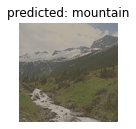

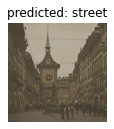

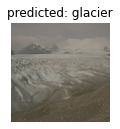

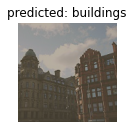

In [ ]:
visualize_model(model)